In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
import keras

from keras import backend as kb
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Layer, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import TensorBoard

<center><h1>Hand writing recognition by Hristina Aleksandrova</h1></center>

![img](img.jpg)

<container>This notebook present an handwritting regcognition model build with **Connectionist Temporal Classification CTC , based on CNN, RNN with bidirectional LSTMs**</container>

<ul><b>Summary:</b></ul>
<li>Loading the data</li>
<li>Data preprocess</li>
<li>Creating Model</li>
<li>Creating CTC loss function</li>
<li>Fitting and testing the model</li>



This model has been train on a local Jupyter notebook. For better performence set the following parametters:

BATCH_SIZE = 128 

IMG_SIZE = (64, 256)

TRAIN_SIZE = 120000 -> sample(frac=0.5)

VALID_SIZE = 12000 -> sample(frac=0.5)

MAX_LENGHT_LABEL=22

EPOCHS=60

<a href="https://we.tl/t-Jar4JWIa0g">PRESS TO DOWNLOAD THE DATASET</a> or copy the kaggle API command: kaggle datasets download -d landlord/handwriting-recognition

<container>
Handwriting recognition (HWR), also known as Handwritten Text Recognition (HTR), is the ability of a computer to receive and interpret intelligible handwritten input from sources such as paper documents, photographs, touch-screens and other devices. The image of the written text may be sensed "off line" from a piece of paper by optical scanning (optical character recognition) or intelligent word recognition. Alternatively, the movements of the pen tip may be sensed "on line", for example by a pen-based computer screen surface, a generally easier task as there are more clues available. A handwriting recognition system handles formatting, performs correct segmentation into characters, and finds the most plausible words.[1]
</container>

## Why Connectionist Temporal Classification /CTC ?
<hr>
<container>
The paper CTCModel: a Keras Model for Connectionist Temporal Classification appeared in 2019 written by Yann Soullard, Cyprien Ruffino, Thierry Paquet. The Connectionist Temporal Classification is the reference method for dealing with
unsegmented input sequences, i.e. with data that are a couple of observation and label sequences
where each label is related to a subset of observation frames. CTCModel makes use
of the CTC implementation in the Tensorflow backend for training and predicting sequences
of labels using Keras. It consists of three branches made of Keras models: one for training,
computing the CTC loss function; one for predicting, providing sequences of labels; and one
for evaluating that returns standard metrics for analyzing sequences of predictions[2].
More information on <a href="https://arxiv.org/pdf/1901.07957v1.pdf">Theoretical information</a> and <a href="https://stackoverflow.com/questions/57292896/understanding-ctc-loss-for-speech-recognition-in-keras">Practical application</a>
</container>

![img2](img2.png)

In [3]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:
tf.keras.backend.clear_session()

###  Loading the data and cleaning the data:

In [5]:
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

In [6]:
train.head()

FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

In [7]:
 valid.head()

FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP

### Finding max lenght of the labels 

In [8]:
train.describe().T

count  unique              top  freq
FILENAME  330961  330961  TRAIN_06702.jpg     1
IDENTITY  330396  100539           THOMAS  1825

In [9]:
train.shape

(330961, 2)

In [10]:
valid.shape

(41370, 2)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [12]:
train.dtypes, valid.dtypes

(FILENAME    object
 IDENTITY    object
 dtype: object,
 FILENAME    object
 IDENTITY    object
 dtype: object)

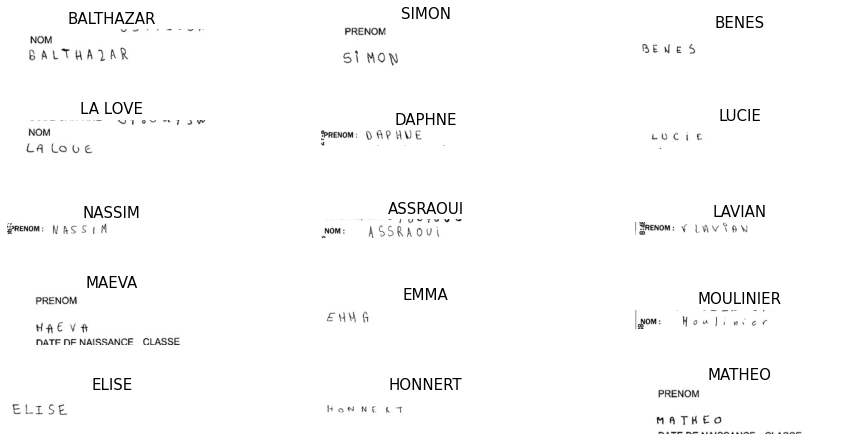

In [13]:
plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=-0.8)

##### Dropping the Null values:

In [14]:
f'Null values train dataset: {train.isnull().sum()}' '\n', f'Null values validation dataset: {valid.isnull().sum()}'

('Null values train dataset: FILENAME      0\nIDENTITY    565\ndtype: int64\n',
 'Null values validation dataset: FILENAME     0\nIDENTITY    78\ndtype: int64')

In [15]:
train.isnull().sum()

FILENAME      0
IDENTITY    565
dtype: int64

In [16]:
valid.isnull().sum()

FILENAME     0
IDENTITY    78
dtype: int64

In [17]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [18]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)



In [19]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

#####  Part of the data is unreadable with label "inreadable". Unfortunately there are also typos, may be there are still others.

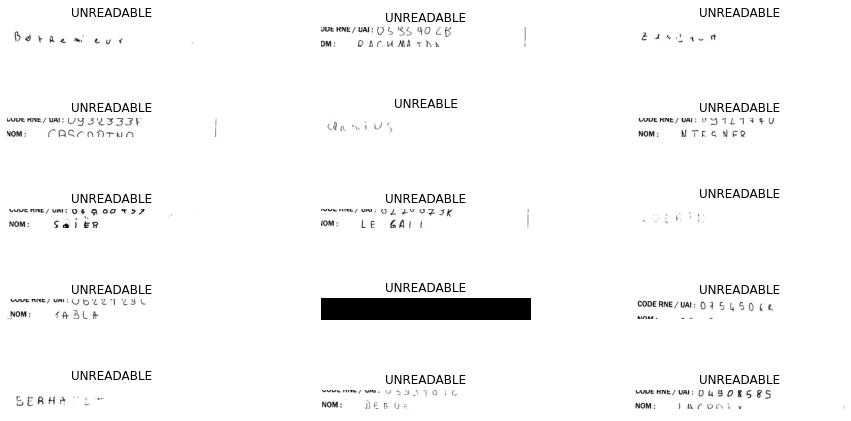

In [20]:
UNREADABLE_LABELS = train[(train['IDENTITY'] == 'UNREADABLE') | (train['IDENTITY'] == 'UNREABLE') | (train['IDENTITY'] == 'UNREDABLE')]
UNREADABLE_LABELS.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    img_dir = 'train_v2/train/'+UNREADABLE_LABELS.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(UNREADABLE_LABELS.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=-0.8)

In [21]:
train.shape

(330396, 2)

In [22]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

##### Setting the main model values:

In [23]:
BATCH_SIZE = 64
IMG_SIZE = (64, 256)
TRAIN_SIZE = 10000
VALID_SIZE = 1000
MAX_LENGHT_LABEL=22
IMAGE_DIR_TRAIN = 'train_v2/train/'
IMAGE_DIR_VALIDATION='validation/validation/'

Because of the particularities of CTC model and loss function label length should be limited.  The loss function accept the following parametters : y_pred - > predicted, y_true - > ground truth, input_length, label_length

In [24]:
max_lenght = 0
labels= np.ravel(train.IDENTITY)
for x in labels:
    try:
        if max_lenght < len(x):
            max_lenght = len(x)
        
    except TypeError:
        continue
print(f'Label with max lenght: {max_lenght}.')

Label with max lenght: 34.


##### Limit the labels lenghts to 22 characters: 
After that reseting the indices 

In [25]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=MAX_LENGHT_LABEL]
valid['Length']=valid['IDENTITY'].apply(lambda x : len(str(x)))
valid=valid[valid['Length']<=MAX_LENGHT_LABEL]


In [26]:
train = train.reset_index()
valid = valid.reset_index()

Grossly, the CTC loss is added on top of a classical network in order to decode a sequential information element by element (letter by letter for text or speech) rather than directly decoding an element block directly (a word for example). A library of the possible characters should be created. This can be done by taking he possible characters from labels or the hard core way manually assining the values in a string. I`m taking all the characters from the labels in the "character"set. 

In [27]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for word in train['IDENTITY'].values:
    for el in word :
        if el not in characters :
            characters.add(el)
characters=sorted(characters)

In [28]:
train

index          FILENAME       IDENTITY  Length
0            0   TRAIN_00001.jpg      BALTHAZAR       9
1            1   TRAIN_00002.jpg          SIMON       5
2            2   TRAIN_00003.jpg          BENES       5
3            3   TRAIN_00004.jpg        LA LOVE       7
4            4   TRAIN_00005.jpg         DAPHNE       6
...        ...               ...            ...     ...
330387  330391  TRAIN_330957.jpg          LENNY       5
330388  330392  TRAIN_330958.jpg        TIFFANY       7
330389  330393  TRAIN_330959.jpg  COUTINHO DESA      13
330390  330394  TRAIN_330960.jpg         MOURAD       6
330391  330395  TRAIN_330961.jpg        HELOISE       7

[330392 rows x 4 columns]

CTC Model start with CNN Convolutional layers. For this reason the shape of the images should be fixed. Creating a simple image resizing function.

### Image Reshape:

In [29]:
def img_reshape(img):
    (h, w)=img.shape
    reshaped_img = np.zeros([IMG_SIZE[0],IMG_SIZE[1]])
    image=img[:IMG_SIZE[0], :IMG_SIZE[1]]
    reshaped_img[:h, :w]=image
    return reshaped_img.T

### Creating tha tain dataset

Creating the trainning data with resized and normilized images. Reading the images as proposed by the article with OpenCv. The image should be rotated on transposed with ".T" or otherwise rotated with OpenCv rotateclockwise function. The model starts with convolutional layer that`s why the dimention of the images should de expaned with "np.expand.dimes()" or "np.array() -> np.reshape()". Reperating the same process for the validation dataset.

In [30]:
TRAIN_DATA = []

for i in range(TRAIN_SIZE):
    
    img_dir = IMAGE_DIR_TRAIN +train.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = img_reshape(img)
    image=img/255.
    TRAIN_DATA.append(image)
    
TRAIN_DATA=np.expand_dims(TRAIN_DATA,3)
    

In [2]:
TRAIN_DATA[0]

NameError: name 'TRAIN_DATA' is not defined

In [32]:
VALIDATION_DATA = []
for i in range(VALID_SIZE):
    img_dir = IMAGE_DIR_VALIDATION +valid.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = img_reshape(img)
    image=img/255.
    VALIDATION_DATA.append(image)

VALIDATION_DATA = np.expand_dims(VALIDATION_DATA,3)    

### Creating Alphabetic dictionnary and decoder - encoder function

The model decode and encode the sequence. that is why I`m creating two dictionnaries and two functions : encoder and decoder. The last will decode the sequence into number, the encoder will return sequence. The decoder returns np.array, the econder return string.

In [33]:
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [34]:
label_to_char.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [35]:
NUMBER_OF_CHARACTERS = len(char_to_label.keys()) + 1 # +1 for ctc pseudo blank
NUM_OF_TIMESTEPS = 64 # max length of predicted labels

def decode_label(element:str):
    decode_list=[]    
    for letter in element:
        for k,v in char_to_label.items():
            if letter==k:
                decode_list.append(v)
    return np.array(decode_list)
            
def encode_label(element):   
    encode_str = ""  
    for num in element:
        for k,v in label_to_char.items():
            if num != -1:
                if k == num:
                    encode_str += v
            else:
                break
    return encode_str


In [36]:
list(decode_label('SHEHEREZADA'))


[21, 10, 7, 10, 7, 20, 7, 28, 3, 6, 3]

In [37]:
print(encode_label([21, 10, 7, 10, 7, 20, 7, 28, 3, 6, 3]))

SHEHEREZADA


Preparing the parameters for the CTC model and loss function. They accepts : "model = Model(inputs=[input_data, y_true, input_length,label_length],outputs=loss_out)". The names of the parameters are irrelevant , it is important that they are set well. Limitation on the label legth, variable for the input lenght, ground truth and the input.  Repeating the same process for the validation data.

In [38]:
train_y = np.ones([TRAIN_SIZE, MAX_LENGHT_LABEL]) * -1
train_label_length = np.zeros([TRAIN_SIZE, 1])
train_input_lenght = np.ones([TRAIN_SIZE, 1]) * (NUM_OF_TIMESTEPS-2)
train_output = np.zeros([TRAIN_SIZE])
#mapping:
for i in range(TRAIN_SIZE):
    train_label_length[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= decode_label(train.loc[i, 'IDENTITY'])

In [39]:
valid_y = np.ones([VALID_SIZE, MAX_LENGHT_LABEL]) * -1
valid_label_len = np.zeros([VALID_SIZE, 1])
valid_input_len = np.ones([VALID_SIZE, 1]) * (NUM_OF_TIMESTEPS-2)
valid_output = np.zeros([VALID_SIZE])

for i in range(VALID_SIZE):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= decode_label(valid.loc[i, 'IDENTITY'])    

In [40]:
tf.keras.backend.clear_session()

### Building the model : 
Input shape is mandatory. First starting with CNN layers making convolutions with batchnormalization and and activation "relu". The output activation should be "softmax" as explained in the article. Before the RNN layer the downsizing is mandatory. Additional dense layers can be added but the model is performing well as it is. After the model should be compiled.Alternatively a model can be build with data genetor: <a href="https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly">KERAS DOCUMENTATION GENERATORS</a> .In this case image resizing , batch normalization sohuld be placed directly in the generator. Alternative loss function :SGD.

<i>"A Model is the way to manage a neural network in Keras. It has at least two arguments, the network
input(s) and the network output(s). The network will include all layers required in the computation
of the output given the input. A Keras model contains a number of methods for training the
network and testing and evaluating datasets using batches or generators. At compilation time, the
model is configured for training: one has to provide at least an optimization method (e.g. ’SGD’,
’rmsprop’, ’Adam’) and a loss function.
A CTC loss function requires 4 inputs. In addition to the output of the network and the label
sequence, the length of each sequence is required in order to limit the loss computation to the
sequence lengths. This is crucial for dealing with sequences of variable lengths as sequences are
padded to form a tensor of fixed size which is related to a batch. The output of a recurrent network
is of equal length than the observation sequence. To our knowledge, Keras doesn’t currently support
loss functions with extra parameters so it is not possible to use a CTC loss function in a standard
way (i.e. by only defining a CTC loss when the model is compiled). A solution to make use of the
CTC approach is that the user defines his own loss in a Lambda layer and then instantiates a Model
with the custom loss as output. In this way, the loss computation is not performed in a standard
manner but directly in the graph computations and a dummy loss has to be given when the model
is compiled. A CTC decoding approach can also be defined in a similar way. Based on these
solutions, CTCModel has been defined to make use of the Connectionnist Temporal Classification
approach in a transparent way."</i>

In [41]:
input_data = Input(shape=(256, 64, 1), name='input')

hidden_layer = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Activation('relu')(hidden_layer)
hidden_layer = MaxPooling2D(pool_size=(2, 2), name='max1')(hidden_layer)

hidden_layer = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Activation('relu')(hidden_layer)
hidden_layer = MaxPooling2D(pool_size=(2, 2), name='max2')(hidden_layer)
hidden_layer = Dropout(0.3)(hidden_layer)

hidden_layer = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Activation('relu')(hidden_layer)
hidden_layer = MaxPooling2D(pool_size=(1, 2), name='max3')(hidden_layer)
hidden_layer = Dropout(0.3)(hidden_layer)



hidden_layer = Reshape(target_shape=((64, 1024)), name='reshape')(hidden_layer)
hidden_layer = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(hidden_layer)


hidden_layer = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(hidden_layer)
hidden_layer = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(hidden_layer)


dense = Dense(NUMBER_OF_CHARACTERS, kernel_initializer='he_normal',name='dense')(hidden_layer)
y_pred = Activation('softmax', name='softmax')(dense)

#building the model
model = Model(inputs=input_data, outputs=y_pred)


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

#### Protting the model:

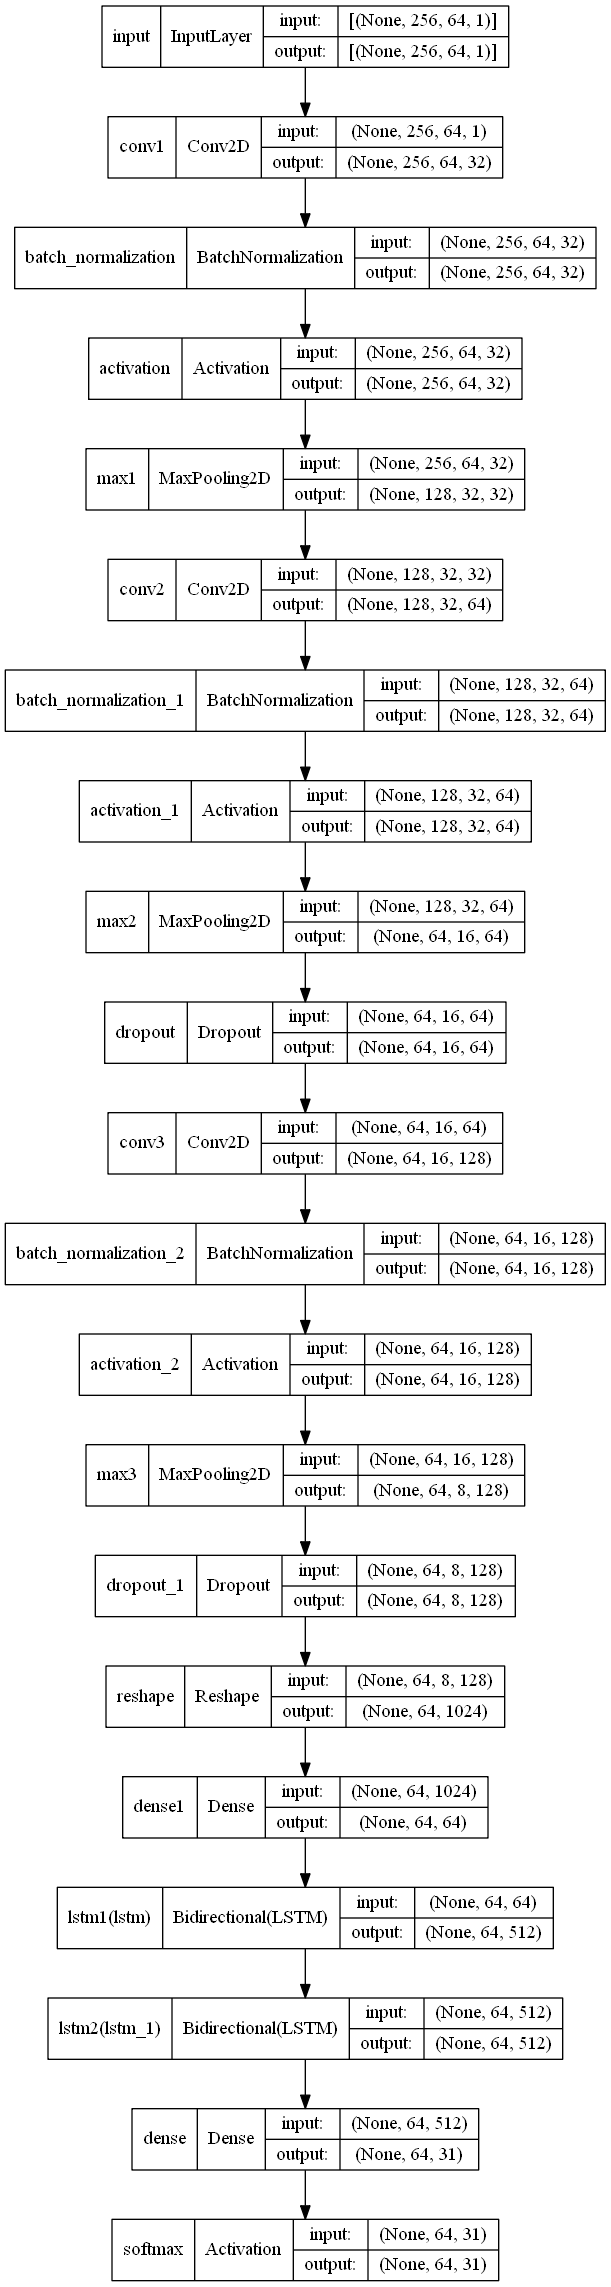

In [43]:
plot_model(model, show_shapes = True)

### Creating the CTC loss lambda function.
<a href="https://stackoverflow.com/questions/57292896/understanding-ctc-loss-for-speech-recognition-in-keras">Link to the example</a>

In [44]:
# Connectionist Temporal Classification Loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return kb.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [45]:
labels = Input(name='gtruth_labels', shape=[MAX_LENGHT_LABEL], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

LOSS = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([model.output, labels, input_length, label_length])
model_build = Model(inputs=[input_data, labels, input_length, label_length], outputs=LOSS)

In [46]:

model_build.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = "adam", metrics = ["accuracy"])

model_build.fit(x=[TRAIN_DATA, train_y, train_input_lenght, train_label_length], y=train_output, 
                validation_data=([VALIDATION_DATA, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=15, batch_size=BATCH_SIZE,callbacks=TensorBoard())

Epoch 1/15
157/157 [==============================] - 38s 124ms/step - loss: 22.1879 - accuracy: 0.0000e+00 - val_loss: 21.7324 - val_accuracy: 0.0000e+00
Epoch 2/15
157/157 [==============================] - 17s 109ms/step - loss: 19.9200 - accuracy: 0.0000e+00 - val_loss: 21.6692 - val_accuracy: 0.0000e+00
Epoch 3/15
157/157 [==============================] - 18s 116ms/step - loss: 19.2942 - accuracy: 0.0000e+00 - val_loss: 22.7645 - val_accuracy: 0.0000e+00
Epoch 4/15
157/157 [==============================] - 17s 111ms/step - loss: 16.4653 - accuracy: 0.0000e+00 - val_loss: 13.8157 - val_accuracy: 0.0000e+00
Epoch 5/15
157/157 [==============================] - 17s 110ms/step - loss: 8.3576 - accuracy: 0.0014 - val_loss: 11.1741 - val_accuracy: 0.0020
Epoch 6/15
157/157 [==============================] - 17s 110ms/step - loss: 5.2383 - accuracy: 0.0397 - val_loss: 6.6503 - val_accuracy: 0.0480
Epoch 7/15
157/157 [==============================] - 17s 109ms/step - loss: 3.9581 - acc

#### Preparing for predictions:

In [47]:
predictions = model.predict(VALIDATION_DATA)
decoded = kb.get_value(kb.ctc_decode(predictions, input_length=np.ones(predictions.shape[0])*predictions.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(VALID_SIZE):
    prediction.append(encode_label(decoded[i]))

### Calculating the correctly predicted words and charactes simple function:

In [49]:

gorund_truth = valid.loc[0:VALID_SIZE, 'IDENTITY'] 
correct_char = 0
total_char = 0
correct = 0
for i in range(VALID_SIZE):
    pr = prediction[i]
    tr = gorund_truth[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/VALID_SIZE))

Correct characters predicted : 88.46%
Correct words predicted      : 68.80%


### Testing the model and plotting the results:
Testing using exactly the same approche. Image reshaping function. Image normalization and addining extradiemtion for the convolution.

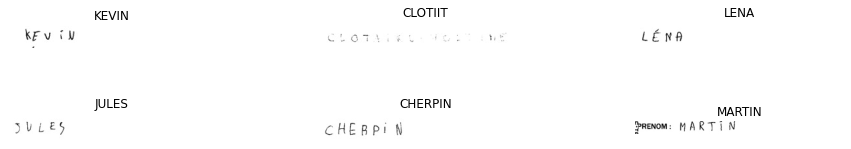

In [50]:
test = pd.read_csv('written_name_test_v2.csv')
# test = pd.read_csv('t.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = img_reshape(image)
    image = image/255.
    
  
    pred = model.predict(image.reshape(1, 256, 64, 1))
#     pred = model.predict(image.np.expand_dims(image,3))
    decoded = kb.get_value(kb.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(encode_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.5, hspace=-0.8)

<i><b>References:</b></i><br>
<font size =0.5><i>[1]Handwriting recognition: https://en.wikipedia.org/wiki/Handwriting_recognition#:~:text=Handwriting%20recognition%20(HWR)%2C%20also,touch%2Dscreens%20and%20other%20devices.</i></font><br>
